### Свои эксперементы я решила начать с обучения моделей логистической регрессии коробочного варианта и реализацией с нуля. Вдруг алгоритмов этих моделей мне хватит для того, чтобы классифицировать 75 пород собак без использования более сложных архитектур
### Эксперементы проводятся на скоращенном датасете - 10 пород

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

### 1. Реализация логистической регрессии с использованием коробочного варианта (nn.Linear)
#### оптимизатор - Adam
#### функция потерь - CrossEntropyLoss

In [20]:
X = np.load('dog_features.npy')  # Загрузка фичей
y = np.load('dog_labels.npy')    # Загрузка меток

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Конвертация в тензоры
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

input_dim = X.shape[1]
output_dim = len(np.unique(y))
model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

best_f1 = 0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        
        val_loss = criterion(val_outputs, y_val_tensor)
        val_precision, val_recall, val_f1 = calculate_metrics(y_val_tensor.numpy(), val_preds.numpy())
        
        # Сохраняем лучшую модель
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_log_reg.pth')
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}')
        print(f'Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}\n')


Epoch [10/100]
Train Loss: 0.0277 | Val Loss: 0.1538
Val Precision: 0.9506 | Val Recall: 0.9488 | Val F1: 0.9492

Epoch [20/100]
Train Loss: 0.0509 | Val Loss: 0.1436
Val Precision: 0.9552 | Val Recall: 0.9535 | Val F1: 0.9539

Epoch [30/100]
Train Loss: 0.0148 | Val Loss: 0.1394
Val Precision: 0.9643 | Val Recall: 0.9628 | Val F1: 0.9632

Epoch [40/100]
Train Loss: 0.0311 | Val Loss: 0.1379
Val Precision: 0.9688 | Val Recall: 0.9674 | Val F1: 0.9677

Epoch [50/100]
Train Loss: 0.0350 | Val Loss: 0.1394
Val Precision: 0.9638 | Val Recall: 0.9628 | Val F1: 0.9628

Epoch [60/100]
Train Loss: 0.0131 | Val Loss: 0.1383
Val Precision: 0.9638 | Val Recall: 0.9628 | Val F1: 0.9628

Epoch [70/100]
Train Loss: 0.0283 | Val Loss: 0.1418
Val Precision: 0.9638 | Val Recall: 0.9628 | Val F1: 0.9628

Epoch [80/100]
Train Loss: 0.0184 | Val Loss: 0.1388
Val Precision: 0.9638 | Val Recall: 0.9628 | Val F1: 0.9628

Epoch [90/100]
Train Loss: 0.0228 | Val Loss: 0.1397
Val Precision: 0.9638 | Val Recall:

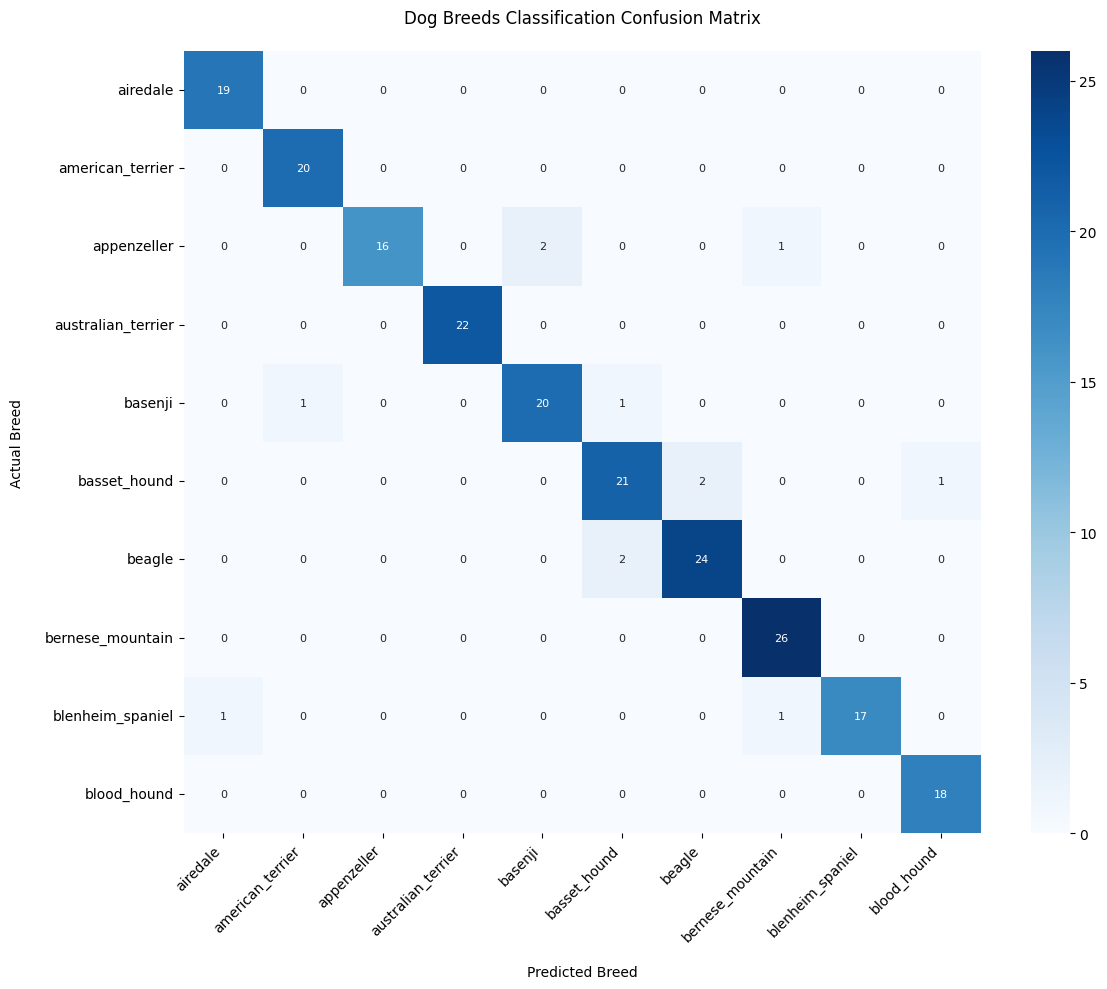


Final Test Metrics:
Accuracy: 0.9442
Precision: 0.9455
Recall: 0.9442
F1 Score: 0.9437



In [21]:
# Тестирование лучшей модели
model.load_state_dict(torch.load('best_model_log_reg.pth'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    
    # Конвертируем тензоры в numpy
    y_test_np = y_test_tensor.numpy()
    test_preds_np = test_preds.numpy()
    
    test_precision, test_recall, test_f1 = calculate_metrics(y_test_np, test_preds_np)
    test_accuracy = (test_preds == y_test_tensor).float().mean()
    
    data_root = "C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs10"
    class_names = sorted(os.listdir(data_root))
        
    # Сonfusion matrix
    cm = confusion_matrix(y_test_np, test_preds_np)
    
    # Визуализация
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 8})
    
    plt.title('Dog Breeds Classification Confusion Matrix', pad=20)
    plt.xlabel('Predicted Breed', labelpad=15)
    plt.ylabel('Actual Breed', labelpad=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('dog_breeds_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('\nFinal Test Metrics:')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1:.4f}\n')

#### ВЫВОД: Модель показала высокую эффективность на 10 классов, ошибаясь лишь в 5,6% случаев. Достаточно неплохой результат, но мне захотелось попробовать реализовать самостоятельно данную архитектуру, чтобы лучше понять ее устройство и протестировать на данных

### 2. Реализация логистической регрессии реализованная с нуля
 #### Изначально архитектура расчитана на бинарную классификацию, но я применила стратегию One-vs-Rest и получилось адаптировать модель под мою задачу

In [23]:
class SLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, h, y):
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            z = np.dot(X, self.weights) + self.bias
            h = self._sigmoid(z)
            
            dw = np.dot(X.T, (h - y)) / n_samples
            db = np.mean(h - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold


Тестовые метрики:
Accuracy: 0.9164
Precision: 0.9220
Recall: 0.9164
F1-score: 0.9157


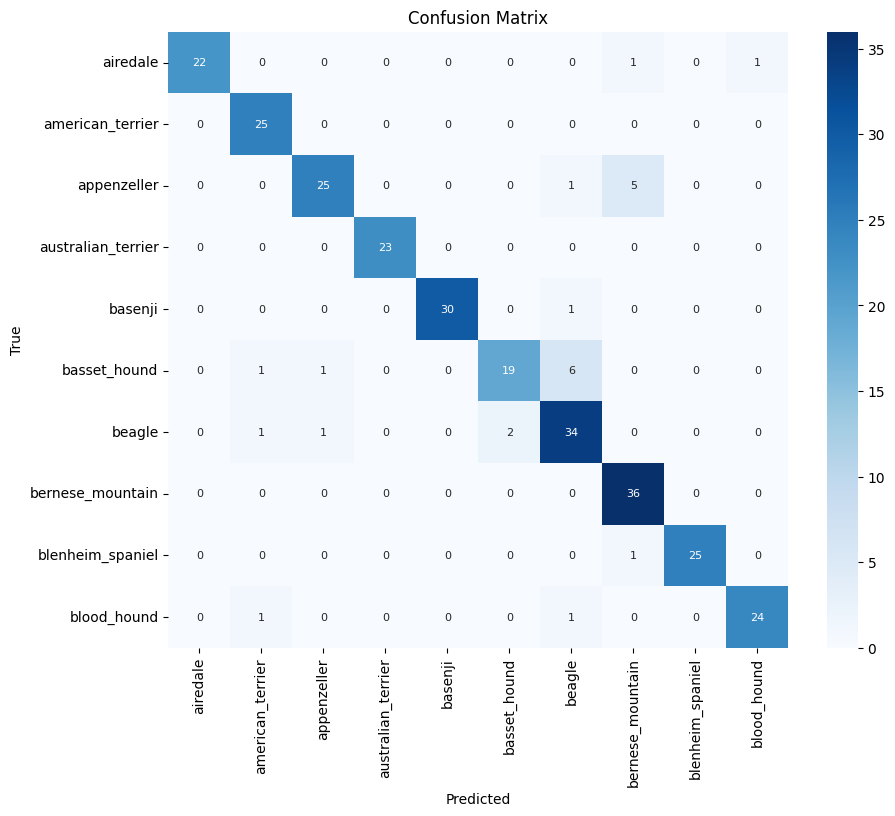

In [25]:
X = np.load('dog_features.npy')
y = np.load('dog_labels.npy')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели (One-vs-Rest)
classifiers = []
num_classes = len(np.unique(y))

for breed_class in range(num_classes):
    y_binary = (y_train == breed_class).astype(int)
    lr = SLogisticRegression(learning_rate=0.1, n_iterations=1000)
    lr.fit(X_train, y_binary)
    classifiers.append(lr)

model_dict = {
    'classifiers': classifiers,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'num_classes': num_classes,
    'class_names': class_names  
}

torch.save(model_dict, 'best_log_reg.pth')

def load_model(path):
    loaded_data = torch.load(path)
    loaded_scaler = StandardScaler()
    loaded_scaler.mean_ = loaded_data['scaler_mean']
    loaded_scaler.scale_ = loaded_data['scaler_scale']
    
    return {
        'classifiers': loaded_data['classifiers'],
        'scaler': loaded_scaler,
        'class_names': loaded_data['class_names']
    }

model_data = load_model('best_log_reg.pth')

# Функция для многоклассового предсказания
def predict_multiclass(X, model_data):
    X = model_data['scaler'].transform(X)
    scores = np.array([clf.predict_proba(X) for clf in model_data['classifiers']])
    return np.argmax(scores, axis=0)

# Оценка модели
y_pred = predict_multiclass(X_test, model_data)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nТестовые метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
data_root = "C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs10"
class_names = sorted(os.listdir(data_root))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Визуализация
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train)

# plt.figure(figsize=(10, 6))
# for class_idx in range(num_classes):
#     plt.scatter(X_pca[y_train == class_idx, 0], 
#                 X_pca[y_train == class_idx, 1], 
#                 label=class_names[class_idx],  
#                 alpha=0.6,
#                 s=50)

# plt.title("PCA Visualization of Dog Breeds", fontsize=14)
# plt.xlabel("Principal Component 1", fontsize=12)
# plt.ylabel("Principal Component 2", fontsize=12)
# plt.tight_layout()
# plt.savefig('dog_breeds_pca.png', dpi=300, bbox_inches='tight')
# plt.show()

#### ВЫВОД: Все метрики получились больше 91%, что говорит о хорошей предсказывающей способности. Метрики получились чуть хуже, чем у предыдущего варианта, но тем не менее являются достаточными для классификации пород

### ОБЩИЙ ВЫВОД: Данные модели показали неплохие результаты на сокращенном датасете (10 пород), но при этом сильно зависили от передаваемых фич и лэйблов. Появилась теория, что на полном датасете (75 пород) данные модели могут справляться хуже, чем сейчас, поэтому я решила попробовать более сложную архитектуру, а именно ResNet с разными вариациями функции потерь и оптимизаторами. После обучения этих моделей я сравню результаты и выберу наиболее подходящую для решения моей задачи